In [3]:
input_sent = 'I had fun today with my friends, I enjoy being with them and celebrating life'

In [4]:
import pandas as pd
import bisect
import re
import nltk
import numpy as np
import string
import spacy
import requests
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import tokenize
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from PIL import Image

In [5]:
train_dataset = pd.read_csv('lemmatized_keyword_ngrams.csv')

In [6]:
# stopwordök:
more_trash = ["’","","``",",","``","]","ace","one","two","three","four","five","six","seven","eight","nine","ten","page","knight",
              "queen","king","cups","wands","swords","pentacles","world","judgement","sun","moon","star","tower","devil",
              "temperance","death","hanged man","justice","wheel","fortune","hermit","strength","chariot","lovers","hierophant",
              "emperor","empress","priestess","magician","fool"]
# így kiszed minden stopwördöt
stoplist = set(stopwords.words('english') + list(punctuation) + list(more_trash))
# így csak a punctuations és a kártyák neveit
#stoplist = set(list(punctuation) + list(more_trash))

# language modell:
nlp = spacy.load("en_core_web_md")

# csak ezeket a pos-okat lemmatizálom (ez az egyszerűség kedvéért van)
pos_list = ['ADJ', 'ADJ_SAT', 'ADV', 'NOUN', 'VERB']
lem_pos_list =['a', 's', 'r', 'n', 'v']
wordnet_lemmatizer = WordNetLemmatizer()

# ezek az oszlopnevekhez kellenek:
list_of_feature_cols_str = [str(i) for i in range(0, 300)]
list_of_feature_cols = [i for i in range(0, 300)]

In [7]:
# ez az összes mondathoz tartozó embedded vektor a tanuló adatbázisból, lista formátumban
train_embed_vector = [
    list(train_dataset[list_of_feature_cols_str].iloc[i, :])
    for i in range(len(train_dataset))
]

In [9]:
elements = [word.lower() for word in input_sent]
# kiszedem a maradék speciális karaktereket is
no_punct = "".join(
        [
            letter
            for letter in elements
            if letter not in string.punctuation and letter != "’"
        ])
# tokenizálok, kiszedem a stopwordöket
raw_words = tokenize.word_tokenize(no_punct)
clean_words = [word for word in raw_words if word not in stoplist]
# lemmatizálok
lem_ngram = []
for word in clean_words:
    sen = nlp(word)
    senpos = sen[0].pos_
    if senpos not in pos_list:
        lemmatized_word = word
    else:
        lem_pos = lem_pos_list[pos_list.index(senpos)]
        lemmatized_word = wordnet_lemmatizer.lemmatize(word,pos=lem_pos)
    lem_ngram.append(lemmatized_word)
lem_ngram_concat = ' '.join(lem_ngram)
# csekkolom, van-e n-gram amit külön kell kezelni
keep_ngrams = [row for row in train_dataset["words"] if row in lem_ngram]
# ha van ilyen, azt beteszem a többi szó közé
if len(keep_ngrams)>0:
    input_lem_ngrams = lem_ngram + keep_ngrams
else:
    input_lem_ngrams = lem_ngram

In [10]:
# szavanként (vagyis ngramoknént/tokenenként) szeretném az embeddinget
descriptions_dict = {}
for token in input_lem_ngrams:
    text = str(token)
    doc = nlp(text)
    vector_for_pred = doc.vector
    entity = list(doc.ents)
    descriptions_dict.update({text: vector_for_pred})
    documents_df_for_pred = pd.DataFrame.from_dict(descriptions_dict, orient="index")

In [11]:
# ez lesz majd az input a fának:
inputtext_df_data = documents_df_for_pred[list_of_feature_cols]
testData = inputtext_df_data
testData.columns = testData.columns.map(str) 
# ez lista formában a vektor - itt még végig kell iterálni
input_embed_vector = list(testData[list_of_feature_cols_str].iloc[0,:])

## cosinus távolság nearest neighbours matchinggel:

In [12]:
train_embed_array = [np.array(element) for element in train_embed_vector]
min_dist_list=[]
min_dist_ind_list=[]
for i in range(len(testData)):
    input_embed_array = [np.array(list(testData[list_of_feature_cols_str].iloc[i,:]))]
    both_vector_lists = np.concatenate( (train_embed_array, input_embed_array ) )
    model = NearestNeighbors(n_neighbors=2, metric="cosine", algorithm="brute", n_jobs=-1)
    nbrs = model.fit(both_vector_lists)
    distances, indices = nbrs.kneighbors(both_vector_lists)
    # minimum index keresése
    min_dist_ind = [element[1] for element in indices]
    min_dist = [element[1] for element in distances]
    min_dist_ind_list.append(min_dist_ind[-1])
    min_dist_list.append(min_dist[-1])

In [13]:
predicted_card_nneighbors = train_dataset['card'][min_dist_ind_list[min_dist_list.index(min(min_dist_list))]]

Legközelebbi kártya nneighbors szerint: World


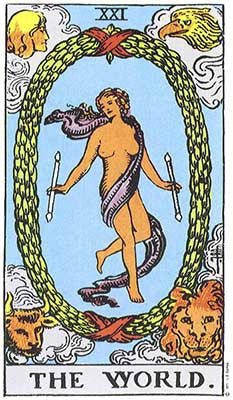

In [14]:
URL = 'https://'+ train_dataset[train_dataset['card']==predicted_card_nneighbors]['img_url'].iloc[0][2:]
im = Image.open(requests.get(URL, stream=True).raw)
print("Legközelebbi kártya nneighbors szerint: " + predicted_card_nneighbors)
im

# megnézem, összességében mennyire sikeres a cos távolság

In [15]:
# ezzel csak megfelelő formátumba hozom a vektorok listáját
train_embed_vector = [
    list(train_dataset[list_of_feature_cols_str].iloc[i, :])
    for i in range(len(train_dataset))
]
# nearest neighbors model
model = NearestNeighbors(n_neighbors=2, metric="cosine", algorithm="brute", n_jobs=-1)
nbrs = model.fit(train_embed_vector)
distances, indices = nbrs.kneighbors(train_embed_vector)
# minimum index keresése
min_dist_ind = [element[1] for element in indices]
# melyik szövegre melyik kártyát tippelte?
predicted_cards = [
    train_dataset["card"][min_dist_ind[i]] for i in range(len(train_dataset))
]
train_dataset["cos_prediction"] = predicted_cards
# mi volt így a sikerráta
success_rate = str(
    round(
        (
            (
                len(
                    train_dataset[
                        train_dataset["card"] == train_dataset["cos_prediction"]
                    ]
                )
                / len(train_dataset)
            )
            * 100
        ),
        2,
    )
)
print(
    "Success rate of cosine distance with nearest neighbours is: " + success_rate + "%"
)

Success rate of cosine distance with nearest neighbours is: 19.04%


In [20]:
# ennyivel valószínűbb, hogy a jó lap jön ki, mintha csak random húznánk
round((float(success_rate)/(1/78)/100),2)

14.85

# megnézem, összességében mennyire sikeres a döntési fa

In [21]:
df = None
def train_test_split_func(y_colname="card", df=df):
    retlist = train_test_split(
        df.drop(y_colname, axis=1).values,
        df[y_colname].values,
        stratify = df[y_colname].values,
        test_size=600,
        random_state=0,
    )

    return [
        pd.DataFrame(f, columns=[f for f in df.columns if not f == y_colname])
        if i < 2
        else pd.DataFrame(f, columns=[y_colname])
        for i, f in enumerate(retlist)
    ]

X_train, X_test, y_train, y_test = train_test_split_func(y_colname="card", df=train_dataset)
params = {"max_depth": 50}
dec_tree = DecisionTreeClassifier(**params).fit(X_train.loc[:, list_of_feature_cols_str], y_train)
test_preds = dec_tree.predict(X_test.loc[:, list_of_feature_cols_str])
compare = pd.DataFrame()
compare["orig"]  = y_test
compare["preds"] = test_preds
compare["text"] = X_test['words']
print(
    "Success rate of decision tree is: "
    + str(
        round(len(compare[compare["orig"] == compare["preds"]]) / len(compare) * 100, 2)
    )
    + "%"
)

Success rate of decision tree is: 4.5%


## kategória döntési fa szerint:
valszeg vhogy összegezni kéne a dimenziókat, mert így szavanként ad egy predikciót, és nem lehet logikusan választani

In [22]:
test_preds_tree = dec_tree.predict(testData.loc[:, list_of_feature_cols_str])

In [23]:
test_pred_tree = test_preds_tree.tolist()[min_dist_list.index(min(min_dist_list))]

Ugyanerre a szóra a döntési fa ezt találta: Ten of Pentacles


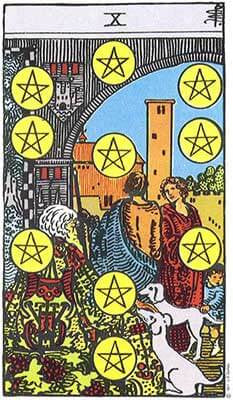

In [24]:
URL = 'https://'+ train_dataset[train_dataset['card']==test_pred_tree]['img_url'].iloc[0][2:]
im = Image.open(requests.get(URL, stream=True).raw)
print("Ugyanerre a szóra a döntési fa ezt találta: " + test_pred_tree)
im